(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

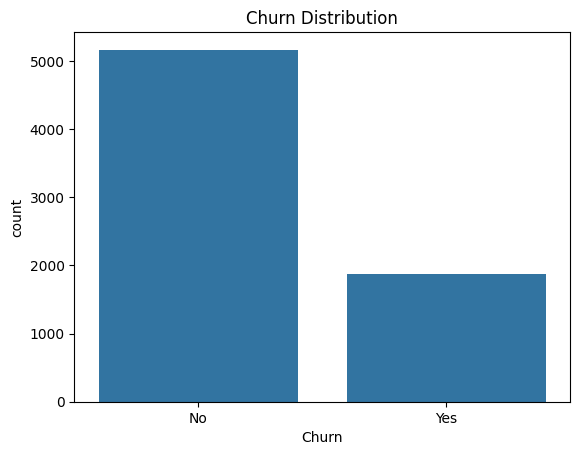

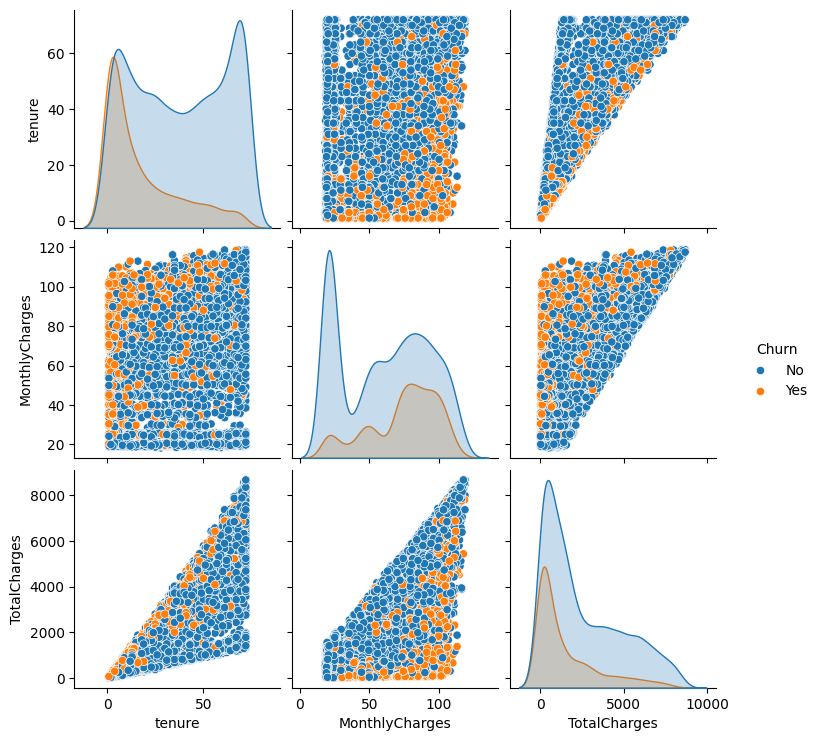

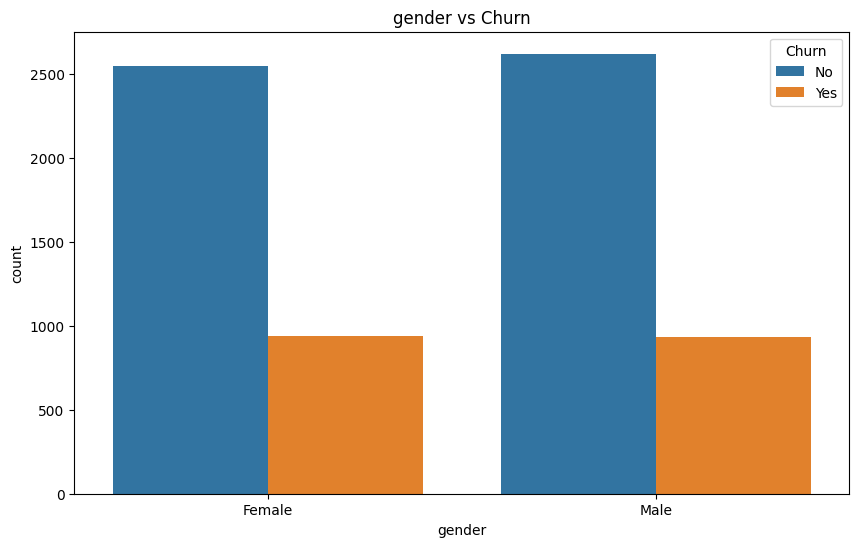

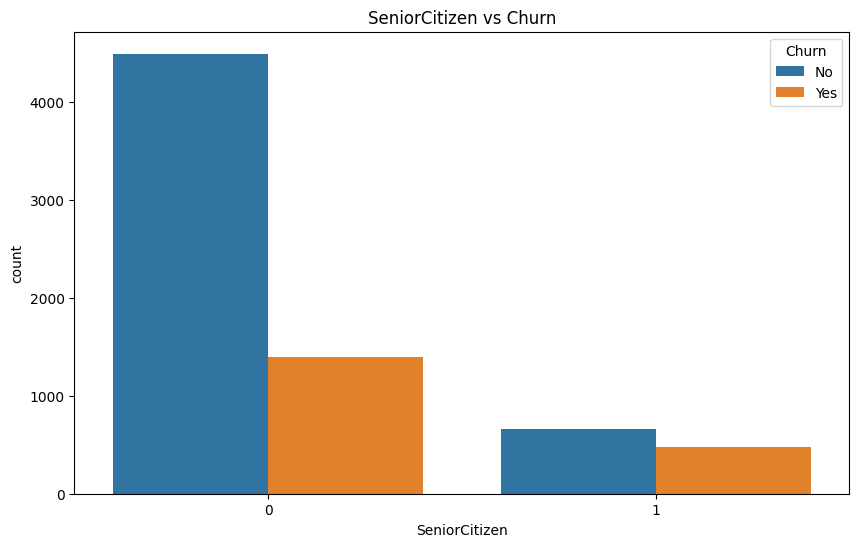

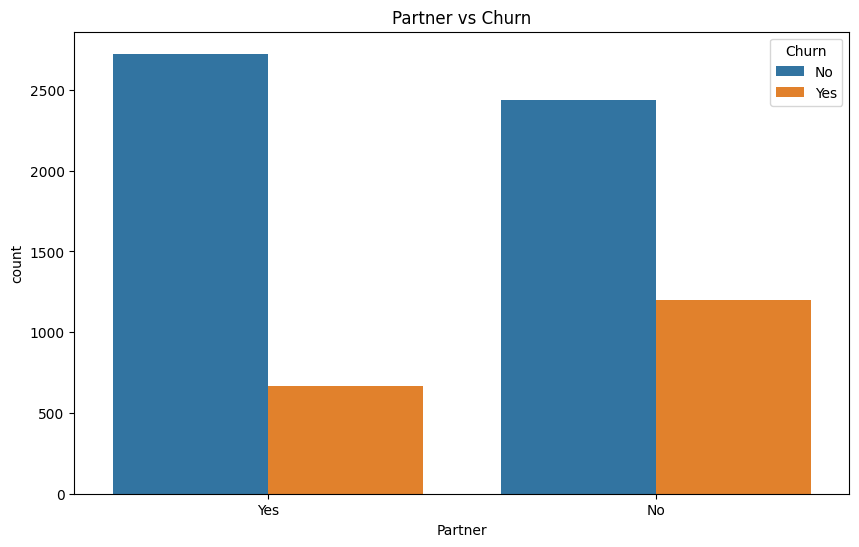

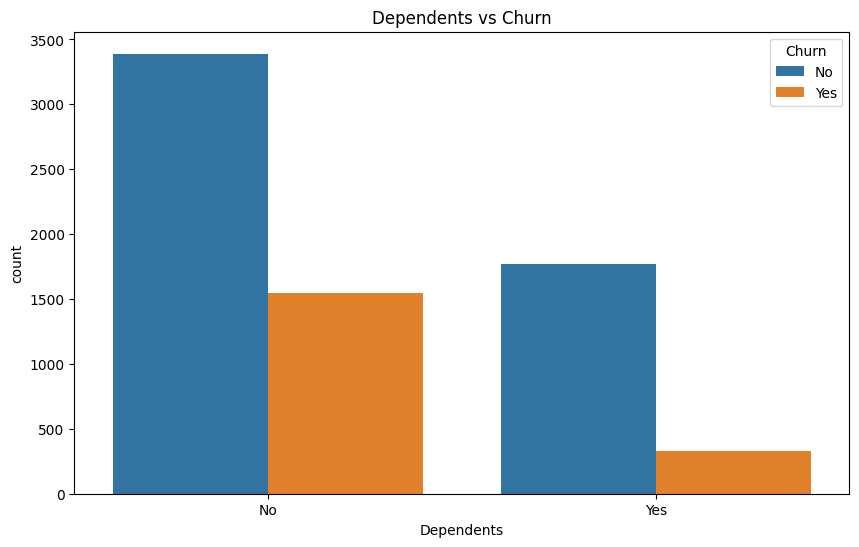

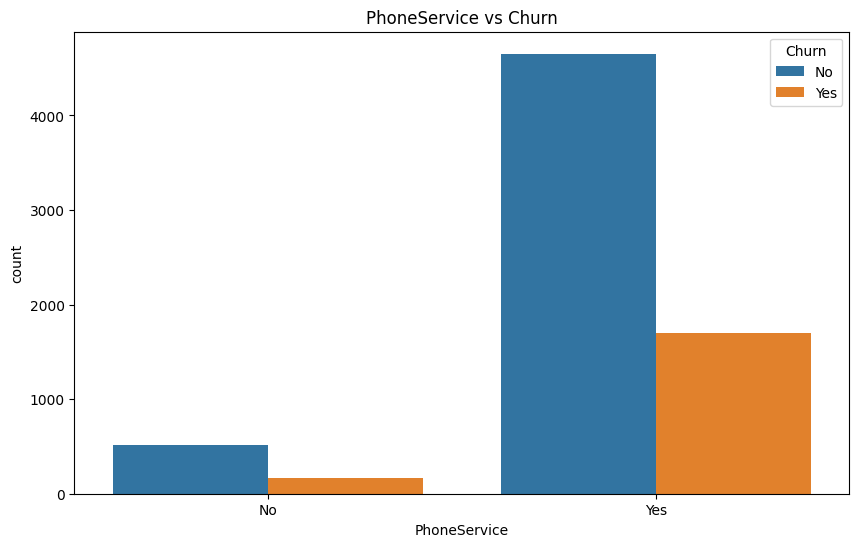

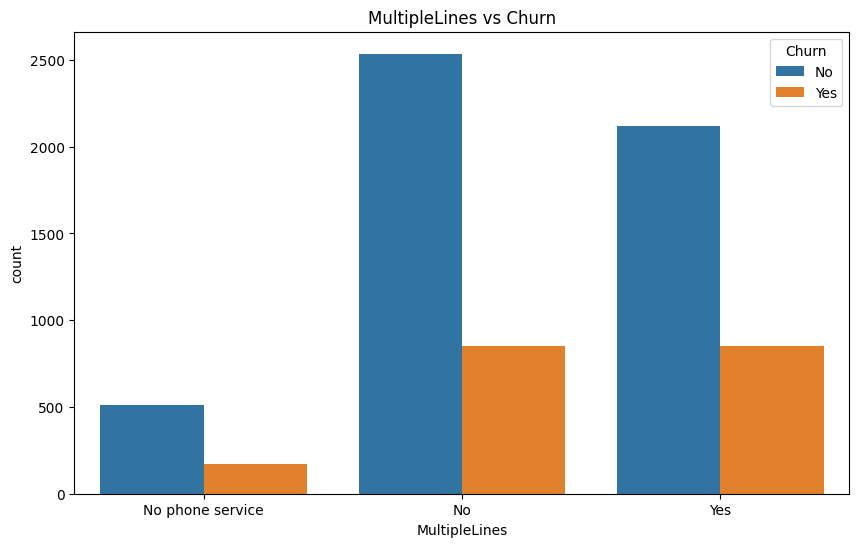

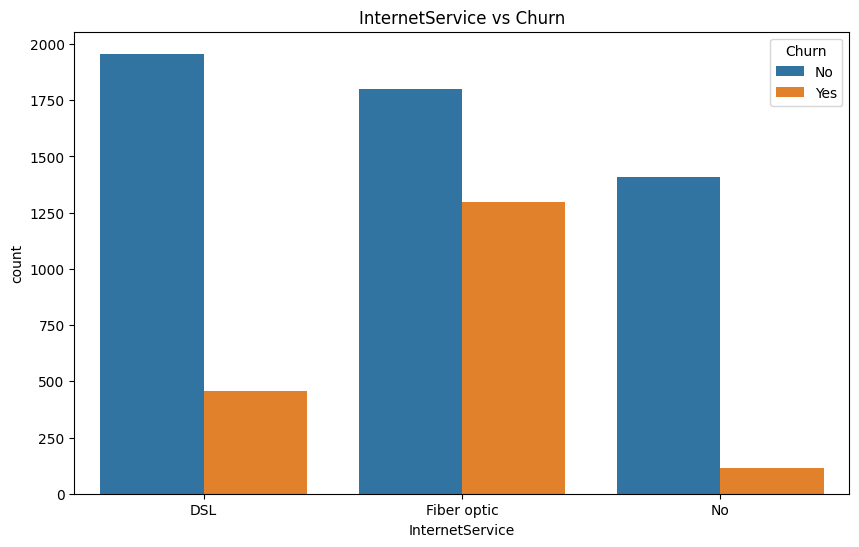

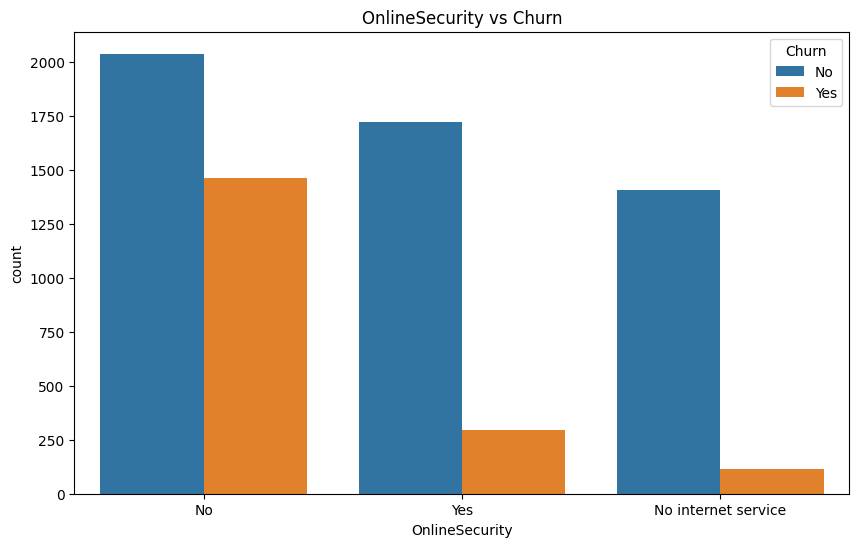

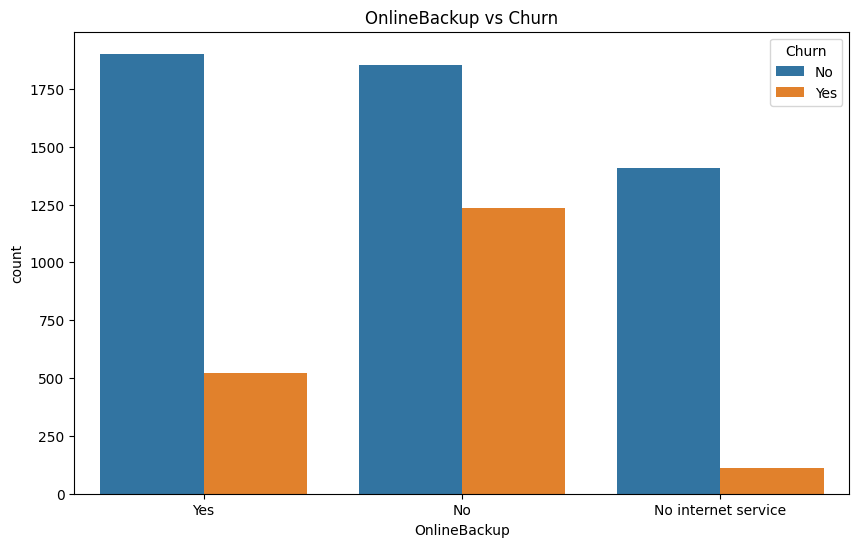

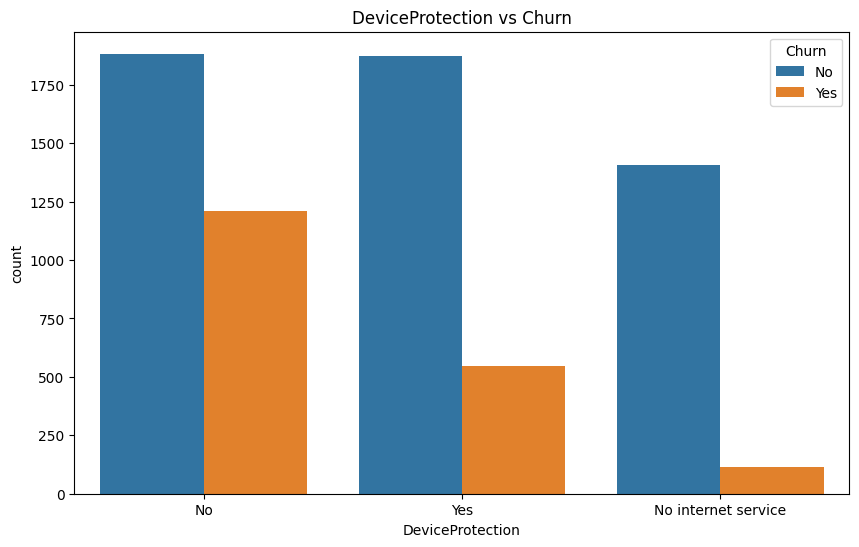

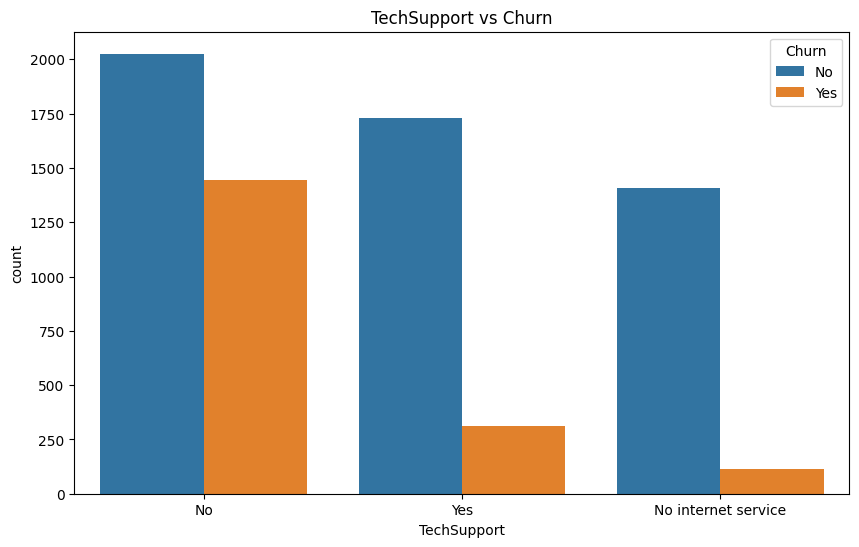

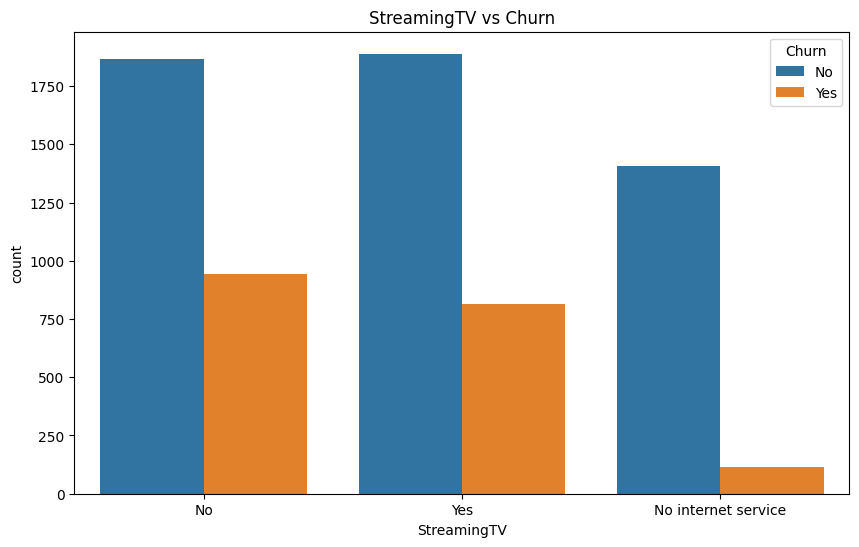

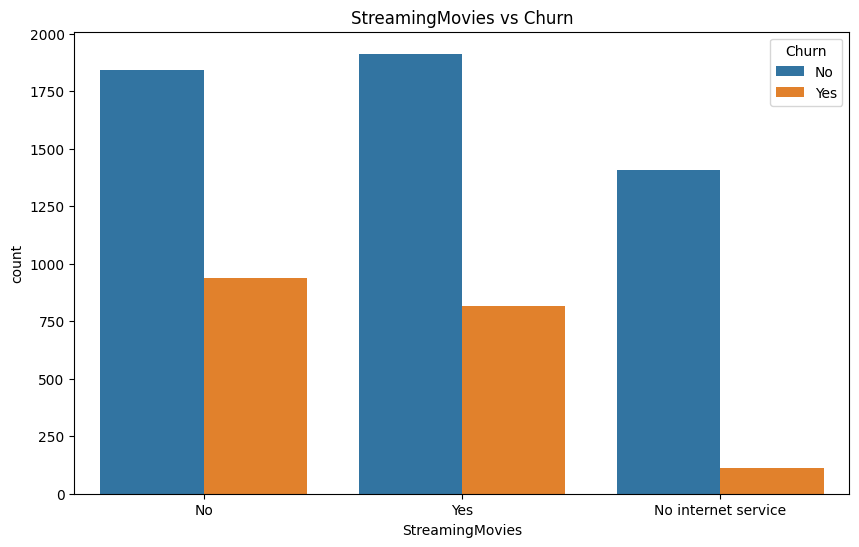

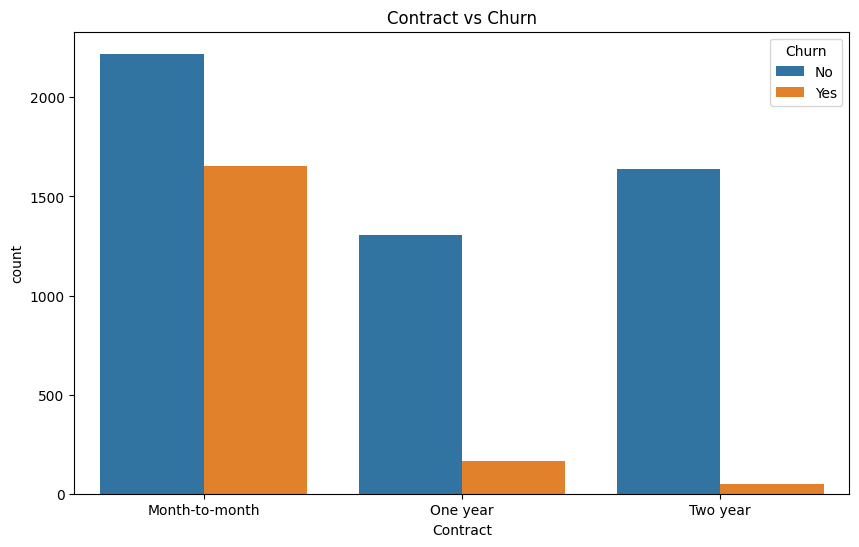

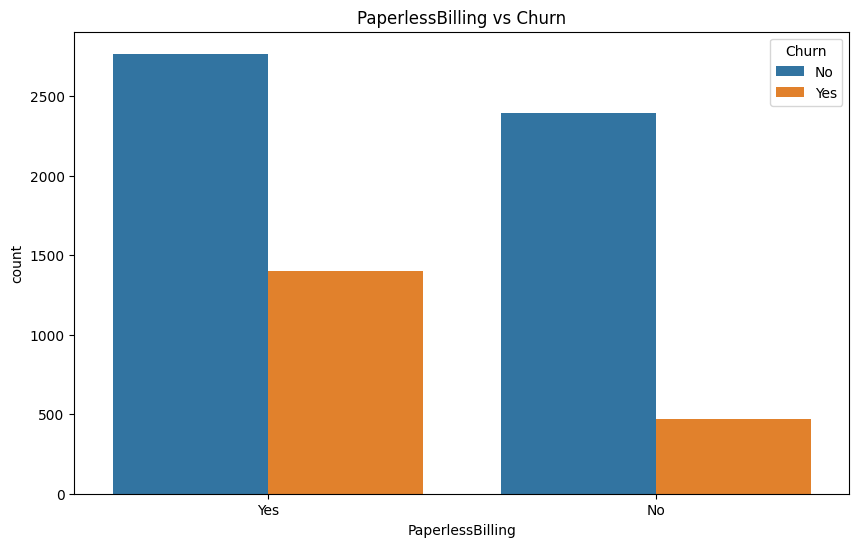

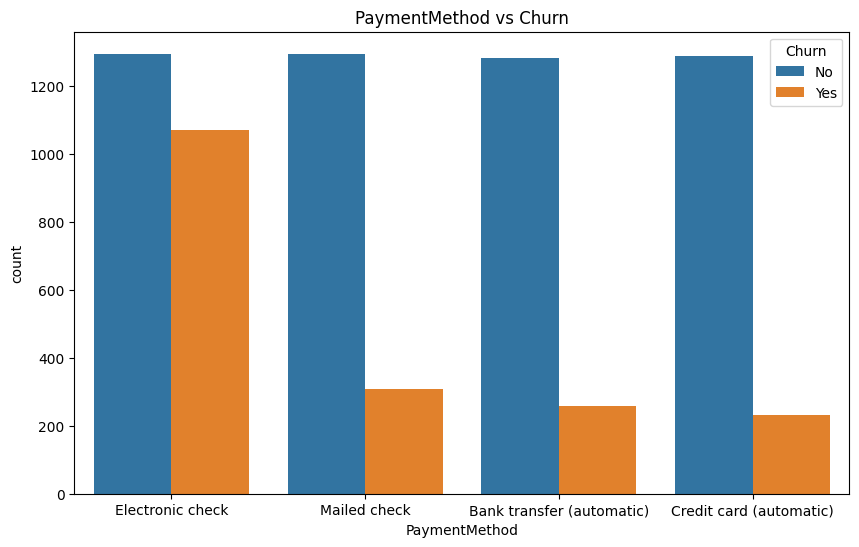

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Telco-Customer-Churn.csv')  

print(df.shape) 
print(df.info())
print(df.describe())


df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.savefig('../diagrams/churn_dist.png') 
plt.show()

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
sns.pairplot(df[numerical_cols + ['Churn']], hue='Churn')
plt.savefig('../diagrams/pairplot.png')
plt.show()

categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.savefig(f'../diagrams/{col}_vs_churn.png')
    plt.show()

## EDA Insights
- Churn rate: ~26%
- Key drivers: Short tenure, high monthly charges, fiber optic service, no tech support.

## Feature Engineering
- Encode categorical variables (binary and one-hot).
- Scale numerical features.
- Split data into train/test sets.

In [30]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib

df.drop('customerID', axis=1, inplace=True)

binary_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

joblib.dump(X_train, '../models/X_train.pkl')
joblib.dump(X_test, '../models/X_test.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

print("X_train shape:", X_train.shape)  
print("X_test shape:", X_test.shape)   
print("y_train distribution:", y_train.value_counts())
print("y_test distribution:", y_test.value_counts())

X_train shape: (5625, 30)
X_test shape: (1407, 30)
y_train distribution: Churn
0    4130
1    1495
Name: count, dtype: int64
y_test distribution: Churn
0    1033
1     374
Name: count, dtype: int64


/tmp/ipykernel_26142/3984685025.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


## Feature Engineering Insights
- Binary variables encoded (0/1).
- Multi-category variables one-hot encoded, increasing features to 40.
- Numerical features scaled using StandardScaler.
- Train/test split maintains ~26% churn rate in both sets.

## Modeling
- Train and evaluate Logistic Regression, Random Forest, and XGBoost.
- Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC.
- Save best model for deployment.

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407

ROC-AUC: 0.7474944479243779
Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC: 0.6961578083666803
XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.59      0.55      0.57       374

    accuracy                           0.78      1407
   macro avg       0.71    

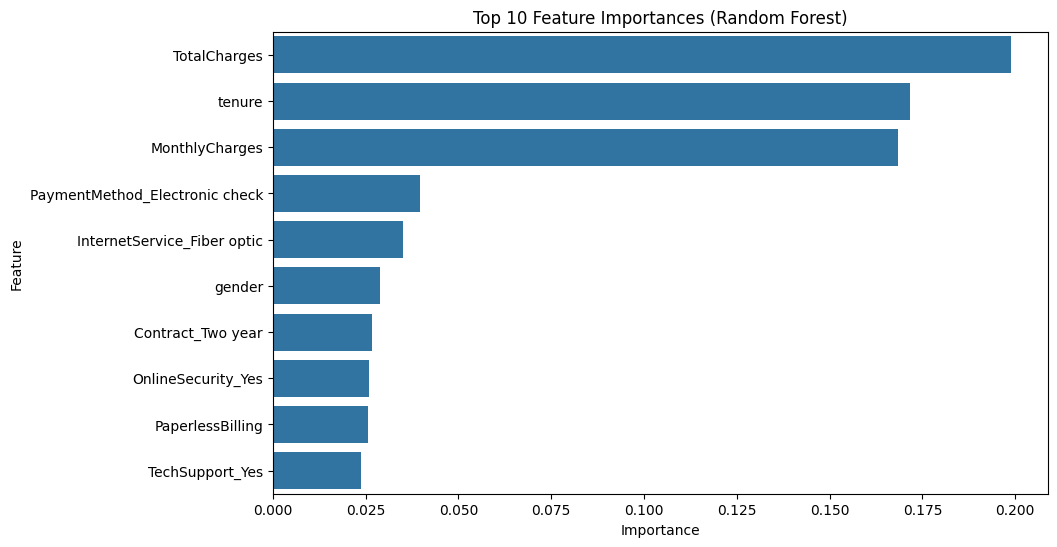

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))

# Save best model (XGBoost)
joblib.dump(lr, '../models/lr_model.pkl')

# Feature importance (Random Forest)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
importances = importances.sort_values('Importance', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.savefig('../diagrams/feature_importance_rf.png')
plt.show()

## Modeling Insights
The performance of the Logistic Regression, Random Forest, and XGBoost evaluated on the customer churn prediction dataset.
- Logistic Regression achieved the highest recall for churners (class 1) at 0.79, indicating it is the best at identifying customers likely to churn. Its ROC-AUC of 0.747 also demonstrates good overall discrimination between churners and non-churners, although its overall accuracy (0.73) is slightly lower than the tree-based models.
- Random Forest showed higher accuracy (0.79) for the dataset overall and good performance for non-churners, but its recall for churners was lower (0.50), meaning it misses more potential churners.
- XGBoost performed moderately, with recall for churners at 0.55 and ROC-AUC of 0.705, making it less effective than Logistic Regression for detecting churn.
- Top features (from Random Forest): tenure, Contract_Month-to-month, MonthlyCharges.
- Saved Logisticmodel for deployment.

Therefore, for deployment in a churn prediction scenario, Logistic Regression with class balancing is preferred because correctly identifying churners (high recall) is critical for retention strategies. Although tree-based models achieve slightly higher overall accuracy, they fail to capture as many potential churners, which is the main objective for our project.

## SHAP Explainability
- SHAP to interpret Logistic Regression predictions.
- Visualize global and local feature importance.

/tmp/ipykernel_26142/1080858756.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)


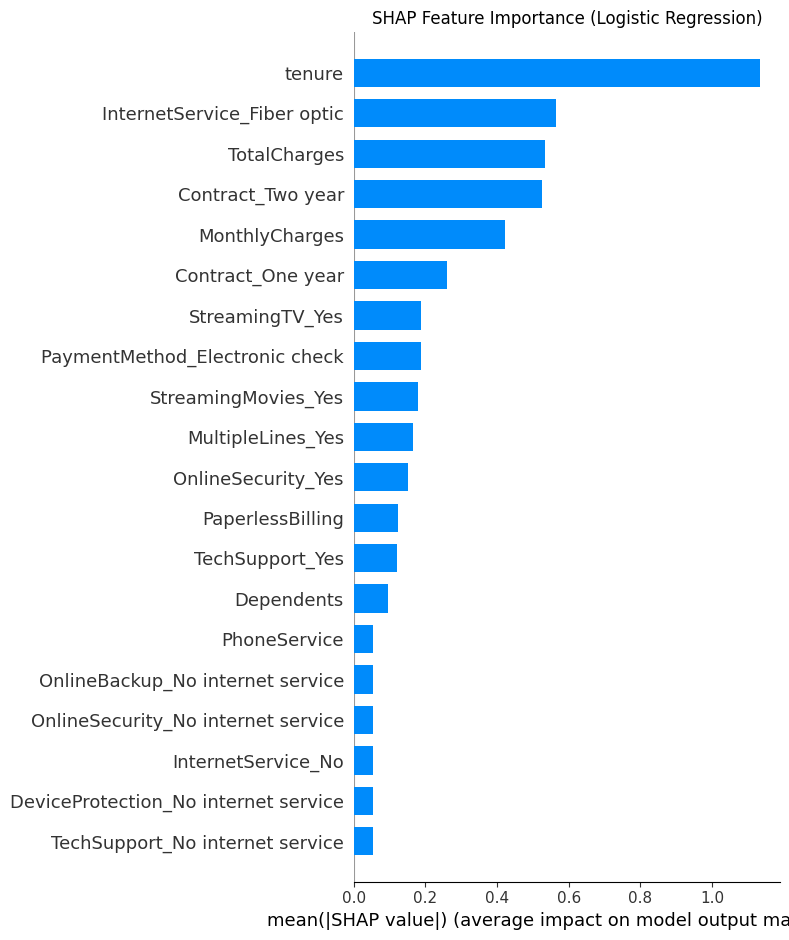

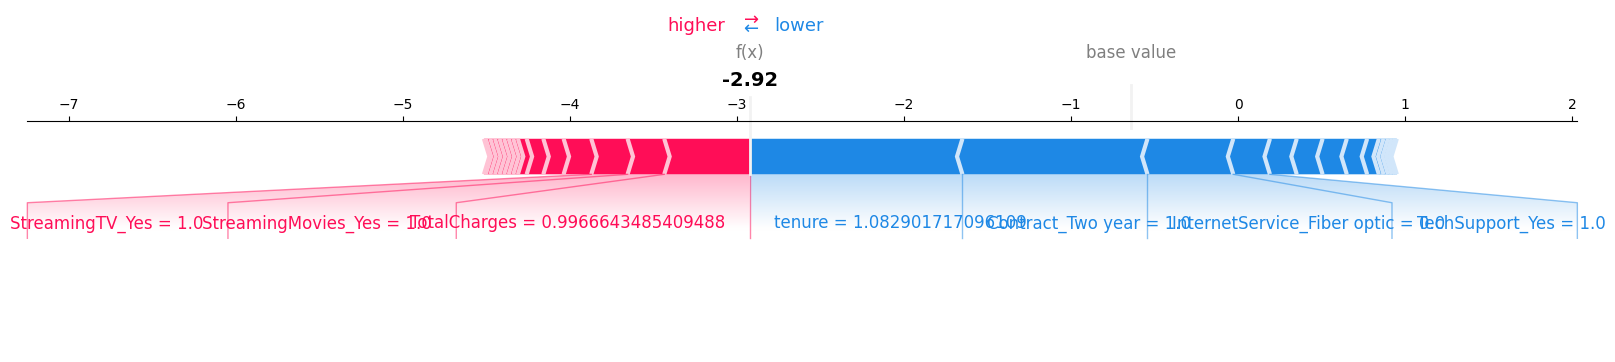

<Figure size 640x480 with 0 Axes>

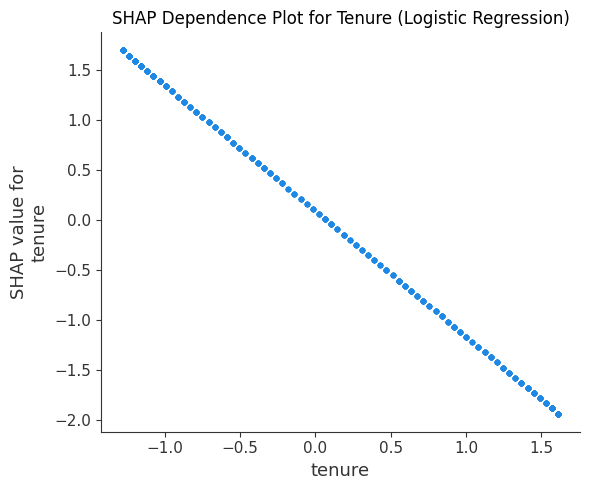

In [ ]:
import shap
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load Logistic Regression model
lr = joblib.load('../models/lr_model.pkl')

# SHAP for Logistic Regression
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_test)

if shap_values.ndim == 1:
    shap_values = np.array([shap_values])  
elif shap_values.shape[1] == X_test.shape[1]:
    shap_values = shap_values  
else:
    raise ValueError("SHAP values shape mismatch with X_test")

# Summary plot (global feature importance)
plt.figure(figsize=(18, 14))
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Logistic Regression)')
plt.tight_layout()
plt.savefig('../diagrams/shap_summary_lr.png')
plt.show()

# Force plot for a single prediction (first test sample)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=True)
plt.savefig('../diagrams/shap_force_lr_0.png')
plt.show()

# Dependence plot for top feature
shap.dependence_plot('tenure', shap_values, X_test, interaction_index=None, show=False)  
plt.title('SHAP Dependence Plot for Tenure (Logistic Regression)')
plt.tight_layout()
plt.savefig('../diagrams/shap_dependence_tenure_lr.png')
plt.show()

Churn rates in A/B groups:
 group
A    0.822695
B    0.517730
Name: churned, dtype: float64


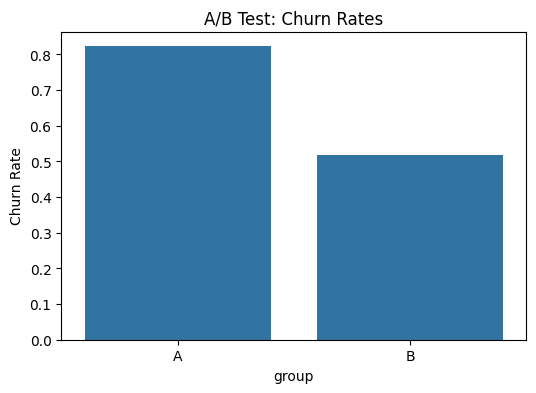

In [33]:
# Predict churn probabilities
y_proba = lr.predict_proba(X_test)[:, 1]

# Top 20% at-risk customers
threshold = np.percentile(y_proba, 80)
at_risk_idx = np.where(y_proba >= threshold)[0]

# Random A/B assignment
np.random.seed(42)
group = np.random.choice(['A', 'B'], size=len(at_risk_idx))

ab_test_df = pd.DataFrame({
    'customer_index': at_risk_idx,
    'group': group,
    'pred_churn_prob': y_proba[at_risk_idx]
})

# Simulate intervention effect
outcome = []
for g, prob in zip(ab_test_df['group'], ab_test_df['pred_churn_prob']):
    if g == 'A':
        outcome.append(np.random.rand() < prob)
    else:
        outcome.append(np.random.rand() < prob * 0.7)

ab_test_df['churned'] = outcome

# Compare churn rates
churn_rates = ab_test_df.groupby('group')['churned'].mean()
print("Churn rates in A/B groups:\n", churn_rates)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.title('A/B Test: Churn Rates')
plt.ylabel('Churn Rate')
plt.savefig('../diagrams/ab_test_churn.png')
plt.show()
